In [1]:
import numpy as np
import random

### Set up plotting

In [2]:
import math
from matplotlib import pyplot as plt

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, sub_titles=None, grayscale=False, cmap=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, math.ceil(len(ims)/rows), i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=14)
        if sub_titles is not None:
            sp.set_title(str(titles[i]) + " (" + str(sub_titles[i]) + ")", fontsize=14)
        plt.imshow(ims[i].reshape((28,28)), interpolation=None if interp else 'none', cmap=cmap)

In [3]:
%matplotlib inline

### Load images

In [4]:
from keras import backend as K
from keras.datasets import mnist as mnist_dataset

class MNISTImages:
    def __init__(self):
        img_rows = img_cols = 28
        
        (X_train, y_train), (X_test, y_test) = mnist_dataset.load_data()

        if K.image_dim_ordering() == 'th':
            X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
            X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
            X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
            
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train /= 255
        X_test /= 255
            
        self.train_input = X_train
        self.train_labels = self.to_categorical(y_train)
        
        self.test_input = X_test
        self.test_labels = self.to_categorical(y_test)
        
    def to_categorical(self,y):
        y = np.array(y, dtype='int').ravel()
        nb_classes = np.max(y) + 1
        n = y.shape[0]
        categorical = np.zeros((n, nb_classes))
        categorical[np.arange(n), y] = 1
        return categorical
    
mnist = MNISTImages()

Using TensorFlow backend.


11403264/11490434 [============================>.] - ETA: 0s

### Set up networks

In [28]:
from keras.models import Model
from keras.optimizers import Nadam
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Activation, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D


g_input = Input(shape=(100,))
g = Dense(7*7*800, activation='relu', input_shape=(100,), kernel_initializer='glorot_normal')(g_input)
g = BatchNormalization()(g)
g = Reshape( [7, 7, 800] )(g)
g = UpSampling2D(size=(2, 2))(g)
g = Conv2D(400, (3, 3), activation="relu", padding="same", kernel_initializer='glorot_uniform')(g)
g = BatchNormalization(axis=3)(g)
g = UpSampling2D(size=(2, 2))(g)
g = Conv2D(200, (3, 3), activation="relu", padding="same", kernel_initializer='glorot_uniform')(g)
g = Conv2D(100, (3, 3), activation="relu", padding="same", kernel_initializer='glorot_uniform')(g)
g = BatchNormalization(axis=3)(g)
g_output = Conv2D(1, (1, 1), activation="sigmoid", padding="same", kernel_initializer='glorot_uniform')(g)


d_input = Input(shape=(28,28,1))
d = BatchNormalization(axis=3)(d_input)
d = Conv2D(10, (3, 3), activation="relu", padding="same")(d)
d = Conv2D(10, (3, 3), activation="relu", padding="same")(d)
d = BatchNormalization(axis=3)(d)
d = Dropout(0.1)(d)
d = MaxPooling2D(pool_size=(2,2))(d)
d = Conv2D(20, (3, 3), activation="relu", padding="same")(d)
d = Dropout(0.2)(d)
d = MaxPooling2D(pool_size=(2,2))(d)
d = Flatten()(d)
d = Dense(128, activation='relu')(d)
d = Dropout(0.45)(d)
d = Dense(1)(d)
d_output = Activation('sigmoid')(d)


opt = Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.006)
dopt = Nadam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.006)

generator = Model(g_input,g_output)
generator.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

discriminator = Model(d_input,d_output)
discriminator.compile(optimizer=dopt, loss='binary_crossentropy', metrics=['accuracy'])

gan_input = Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
GAN = Model(gan_input, gan_output)
GAN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

### Let's see what the generator does by default

In [29]:
def get_random_input_for_generator(n):
    return np.array([[random.random() for i in range(100)] for j in range(n)])

In [30]:
def get_generator_samples(n=8):
    plots(generator.predict(get_random_input_for_generator(n)), cmap='gray', rows=math.ceil(n/4))

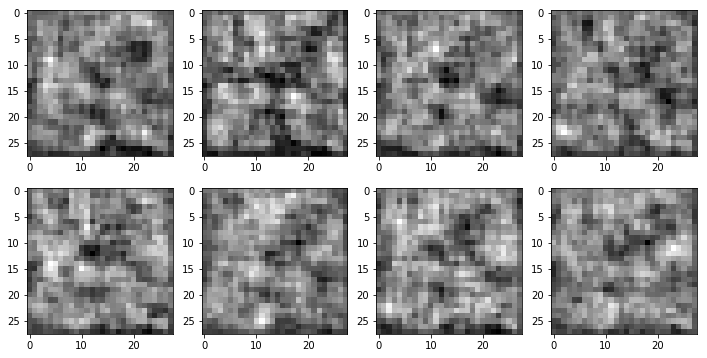

In [31]:
get_generator_samples()

### Train gan

In [32]:
from IPython import display

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

def train_discriminator(batch_size):
    fake_images = np.array(generator.predict(get_random_input_for_generator(batch_size)))
    real_images = mnist.train_input[np.random.randint(0,mnist.train_input.shape[0],size=batch_size),:,:,:]

    training_images = np.concatenate((fake_images, real_images))
    training_labels = np.array([0]*batch_size + [1]*batch_size)

    #make_trainable(discriminator,True)
    return discriminator.train_on_batch(training_images,training_labels)
        
def train_generator(batch_size):
    prior_x = np.array(get_random_input_for_generator(batch_size))
    prior_labels = np.array([1]*batch_size)

    #make_trainable(discriminator,False)
    return GAN.train_on_batch(prior_x, prior_labels)
        
def train_gan(epochs=5000, batch_size=32):
    for i in range(epochs):
        d_loss = train_discriminator(batch_size)
        g_loss = train_generator(batch_size)
        
        if i%50 == 0:
            display.clear_output(wait=True)
            print(i, d_loss[0], g_loss[0], d_loss[1], g_loss[1])
        
        
        

In [33]:
for i in range(300):
    d_loss = train_discriminator(32)
    
    if i%50 == 0:
        display.clear_output(wait=True)
        print(i, d_loss[0], d_loss[1])

250 1.18646e-05 1.0


In [34]:
train_gan(epochs=5000, batch_size=128)

4950 1.09605e-07 1.21072e-07 1.0 1.0


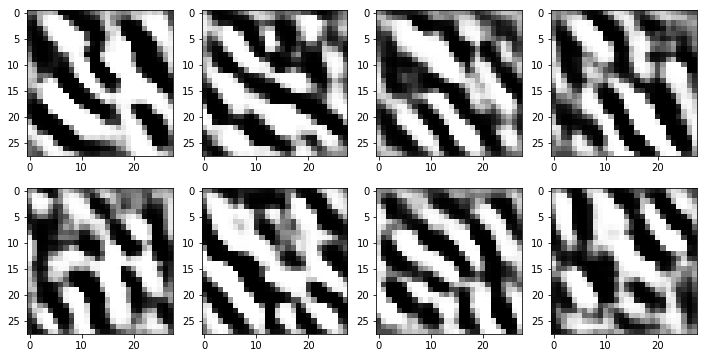

In [35]:
get_generator_samples()

In [ ]:
opt.lr = 1e-3
dopt.lr = opt.lr*10

In [ ]:
train_gan(epochs=500)